In [1]:
class Node:
    def __init__(self, inputs=[], name=None, is_trainable=True):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.is_trainable = is_trainable
        
        for n in self.inputs:
            n.outputs.append(self)
        
        self.value = None
        
        self.gradients = {}
        
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError
    
    def __repr__(self):
        return self.name

In [108]:
class Placeholder(Node):
    def __init__(self, name, is_trainable=True):
        Node.__init__(self, name=name, is_trainable=is_trainable)
        
    def forward(self, value=None):
        if value is not None: self.value = value
    
    def backward(self):
        self.gradients = {}
        for n in self.outputs:
            self.gradients[self] = n.gradients[self] * 1

class Linear(Node):
    def __init__(self, x=None, weigth=None, bias=None, name=None, is_trainable=False):
        Node.__init__(self, [x, weigth, bias], name=name, is_trainable=is_trainable)
        
    def forward(self):
        k, x, b = self.inputs[1], self.inputs[0], self.inputs[2]
        self.value = k.value * x.value + b.value
        
    def backward(self):
        k, x, b = self.inputs[1], self.inputs[0], self.inputs[2]
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[k] = grad_cost * x.value
            
            self.gradients[x] = grad_cost * k.value
            
            self.gradients[b] = grad_cost * 1
    
        
class Sigmoid(Node):
    def __init__(self, x, name=None, is_trainable=False):
        Node.__init__(self, [x], name=name, is_trainable=is_trainable)
        self.x = self.inputs[0]
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x.value)
        
    def partial(self):
        return self._sigmoid(self.x.value) * (1 - self._sigmoid(self.x.value))
    
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x] = grad_cost * self.partial() 
    #    print(self.gradients)
    
    
class Relu(Node):
    def __init__(self, x, name=None, is_trainable=False):
        Node.__init__(self, [x], name=name, is_trainable=is_trainable)
        self.x = x
        
    def forward(self):
        self.value = self.x.value * (self.x.value > 0)
        
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x] = grad_cost * (self.x.value > 0) 
        

class L2_LOSS(Node):
    def __init__(self, y, y_hat, name=None, is_trainable=False):
        Node.__init__(self, [y, y_hat], name=name, is_trainable=is_trainable)
        self.y = y
        self.y_hat = y_hat
        
    def forward(self):        
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.value = np.mean((y_v - yhat_v) ** 2)
        
    def backward(self):
        # 1/n sum (y- yhat)**2
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.gradients[self.y] = 2 * np.mean((y_v - yhat_v))
        self.gradients[self.y_hat] = -2 * np.mean((y_v - yhat_v))
     #   print(self.gradients)

In [4]:
from sklearn.datasets import load_boston

In [5]:
data = load_boston()

In [7]:
X_, y_ = data['data'], data['target']
X_rm = X_[:, 5]

In [8]:
def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))

            need_to_visited = [node]

            if len(graph) == 1: need_to_visited += graph[node]
                
            graph.pop(node)
            sorted_node += need_to_visited
        
            for _, links in graph.items():
                if node in links: links.remove(node)
        else: # have cycle
            break
        
    return sorted_node

In [9]:
from collections import defaultdict

In [10]:
def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

In [11]:
def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)

In [12]:
def forward_and_backward(graph_order, monitor=False):
    # 整体的参数就更新了一次
    for node in graph_order:
        if monitor:
            print('forward computing -- {}'.format(node))
        node.forward()
    
    for node in graph_order[::-1]:
        if monitor:
            print('backward computing -- {}'.format(node))
        node.backward()

In [13]:
def optimize(graph, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in graph:
        if t.is_trainable:
            t.value += -1 * learning_rate * t.gradients[t]

In [14]:
from tqdm import tqdm_notebook

In [18]:
import numpy as np
import random

In [144]:
#from xxxx import Linear, Sigmoid, L2_LOSS, Placeholder


data = load_boston()
X_, y_ = data['data'], data['target']
X_rm = X_[:, 5]

w1_, b1_ = np.random.normal(), np.random.normal()
w2_, b2_ = np.random.normal(), np.random.normal()
w3_, b3_ = np.random.normal(), np.random.normal()


X, y = Placeholder(name='X', is_trainable=False), Placeholder(name='y', is_trainable=False)
w1, b1 = Placeholder(name='w1'), Placeholder(name='b1')
w2, b2 = Placeholder(name='w2'), Placeholder(name='b2')

# build model
output1 = Linear(X, w1, b1, name='linear-01')
output2 = Sigmoid(output1, name='activation')
#output2 = Relu(output1, name='activation')
y_hat = Linear(output2, w2, b2, name='y_hat')
cost = L2_LOSS(y, y_hat, name='cost')

feed_dict = {
    X: X_rm,
    y: y_,
    w1: w1_,
    w2: w2_,
    b1: b1_,
    b2: b2_,
}

graph_sort = topological_sort_feed_dict(feed_dict)

epoch = 5000
batch_num = 100

learning_rate = 1e-3

losses = []

for e in tqdm_notebook(range(epoch)):
    loss = 0
    
    for b in range(batch_num):
        index = np.random.choice(range(len(X_rm)))
        X.value = X_rm[index]
        y.value = y_[index]
    
        forward_and_backward(graph_sort, monitor=False)
    
        optimize(graph_sort, learning_rate)
    
#    if e % 100000 == 0: 
#        print('cost==', cost.value)
        
        loss += cost.value

    losses.append(loss / batch_num)

In [140]:
def predicate(x, graph):
    X.value = x
    forward_and_backward(graph_sort)
    return y_hat.value

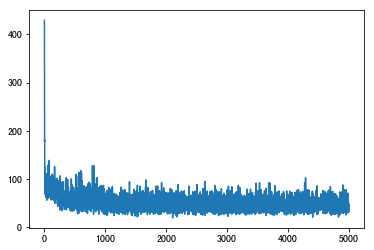

In [145]:
plt.plot(losses)

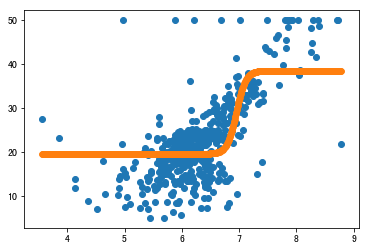

In [146]:
plt.scatter(X_rm, y_)
plot_x = np.linspace(min(X_rm), max(X_rm), 1000)
plt.scatter(plot_x, [predicate(x, graph_sort) for x in plot_x], s=30)

In [77]:
%matplotlib inline

In [78]:
import matplotlib.pyplot as plt

## 深度学习就是一场 Overfitting 和 Underfitting 搏斗的过程

## Outlinear~?